# What's the best portfolio to invest in?

I'm going to look at a few different techniques of how to construct a portfolio and see how they all perform when looking at historical data.

## Data

I'll be using a historical monthly returns dataset categorized by industry from the Ken French data library:
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

I've got the following 4 files:
- 30 industries, equally-weighted returns
- 30 industries, value-weighted returns
- 30 industries, average number of firms
- 30 industries, average size (market cap)

Note: the first two files are the historical returns and 'equally-weighted' and 'value-weighted' describes how these are calculated, since they are industry portfolios. This should not be confused with the type of portfolio we will construct later, which can be value-weighted or equally-weighted.

First, I'll write a few functions to retrieve the right dataset easily.

In [29]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype is "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)

def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_total_market_index_returns():
    ind_return = get_ind_returns()
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_mktcap = ind_nfirms * ind_size
    tot_mktcap = ind_mktcap.sum(axis='columns')
    ind_capweight = ind_mktcap.divide(tot_mktcap, axis='rows')
    total_market_return = (ind_capweight * ind_return).sum(axis='columns')
    return total_market_return

Let's load up the dataset and have a look at it. To make the computations faster, I'll limit the time frame to the year 2000 onwards.

In [86]:
# Import libraries
import numpy as np
import pandas as pd

# Value-weighted industry returns
ind_rets = get_ind_returns(weighting='vw', n_inds=30)['2000':]
# Market caps
ind_mcap = get_ind_market_caps(weights=True)['2000':]

ind_rets.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2000-04,-0.0390,0.0368,0.0379,0.0220,-0.0734,0.0429,0.0430,0.0525,-0.0373,0.0648,...,-0.0790,-0.1655,-0.0630,-0.0109,0.0348,-0.0107,-0.0560,0.0382,-0.0425,0.0819
2000-05,0.1565,0.1187,0.1951,0.0119,-0.0593,0.0279,-0.0504,0.0394,-0.0010,-0.0328,...,-0.1041,-0.0892,-0.1165,-0.0137,-0.0363,0.0193,-0.0304,-0.0421,0.0506,0.0531


In [87]:
ind_mcap.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,0.014375,0.016226,0.004292,0.011955,0.013937,0.019933,0.002959,0.087723,0.015373,0.000617,...,0.088189,0.153083,0.168443,0.012960,0.008700,0.009599,0.065019,0.006775,0.145341,0.004645
2000-02,0.013752,0.016569,0.004098,0.012768,0.014426,0.019434,0.002740,0.098494,0.014564,0.000596,...,0.087839,0.144083,0.174353,0.012322,0.008079,0.010576,0.057995,0.006556,0.144892,0.004603
2000-03,0.012564,0.014402,0.003873,0.012319,0.014069,0.016893,0.002348,0.094039,0.013246,0.000546,...,0.083142,0.151848,0.214275,0.010710,0.007473,0.010504,0.054758,0.005676,0.129981,0.004334
2000-04,0.012895,0.013481,0.003730,0.012755,0.014891,0.013578,0.002747,0.086226,0.013904,0.000539,...,0.083820,0.145797,0.209719,0.010828,0.007900,0.010244,0.058691,0.006159,0.140833,0.004054
2000-05,0.013000,0.014713,0.004047,0.013716,0.014521,0.014801,0.003014,0.095406,0.014089,0.000602,...,0.077986,0.128022,0.206628,0.011273,0.008579,0.010646,0.058296,0.006730,0.141670,0.004616


## Performance Metrics

How do we judge how the portfolios performed? I'll use the following metrics:

- Returns
- Volatility
- Sharpe Ratio
- Drawdown
- Skewness
- Kurtosis
- VaR
- CVaR

I'll now write a few functions to calculate these. Note since I'm using monthly data, I'll write functions for annualizing returns and volatility.

In [88]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns   
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

# Using the above functions, a new function for Sharpe Ratio
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized Sharpe Ratio of a set of returns,
    given a risk-free rate and periods per year
    """
    # Convert the annual riskfree rate to per period rate
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    # Find excess return over the risk-free rate
    excess_ret = r - rf_per_period
    # Annualize the excess return using the annualize_rets function above
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    # Annualize the volatility using the annualize_rets function above
    ann_vol = annualize_vol(r, periods_per_year)
    # Return the Sharpe Ratio
    return ann_ex_ret/ann_vol

# Drawdown i.e. maximum peak to trough drop
def drawdown(return_series: pd.Series):
    """
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index, previous peaks, and percentage drawdowns
    """
    # Compute a wealth index - the value a dollar invested over time
    wealth_index = 1000*(1+return_series).cumprod()
    # Find the previous peak of the wealth index at any point in time
    previous_peaks = wealth_index.cummax()
    # Find the difference between the wealth index and the previous peak
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        'Wealth': wealth_index,
        'Previous Peak': previous_peaks,
        'Drawdown': drawdowns
    })

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number and the (100-level) percent are above
    """
    #If r is a DataFrame, run the function on each of its columns
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    #When we run it on each of the columns, they are no longer DataFrames so 
    #function won't get called again
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

Let's put all these together in a Summary Statistics function

In [89]:
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

We'll use this summary function to evaluate how our portfolios do.

## Baseline Portfolios

First, let's look at a couple of baselines portfolios perform. Here, I'll write functions to return a set of portfolio weights based on these strategies.

### Cap-Weighted Portfolio (CW)

The first baseline is a simple market-cap weighted portfolio. Here's a function that will return portfolio weights based on this strategy.

In [90]:
#Market-cap weighted portfolio (CW)
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of a cap-weighted portfolio, given time series of returns and cap-weights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

### Equally-Weighted Portfolio (EW)

A second baseline is a naive equally-weighted portfolio (a naive strategy allocating equal weights across industries).

In [91]:
def weight_ew(r, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

### Backtesting CW and EW Portfolios

How do these portfolios perform? The function below will backtest these trading strategies.

In [92]:
#Function to backtest a weighting scheme
def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

Using the backtesting function above, how to the baseline portfolios perform?

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
CW,0.077942,0.146264,-0.732819,5.047819,0.068674,0.099002,0.318835,-0.516501


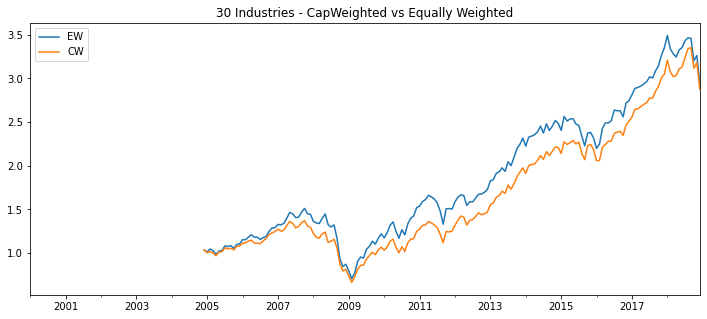

In [93]:
ewr = backtest_ws(ind_rets)
cwr = backtest_ws(ind_rets, weighting=weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5), title="30 Industries - CapWeighted vs Equally Weighted")
summary_stats(btr.dropna())

The naive EW porfolio had better returns than the CW portfolio, but had higher volatility. EW had a slightly better Sharpe Ratio and maximum drawdown, but these numbers are pretty close.

### Improving the EW Portfolio

EW is difficult to implement in practice because you can end up with huge positions in very small companies, and some of these small companies's stocks may not be as liquid.

So, let's make the following 2 improvements to EW:

- Drop microcap stocks beyond a threshold (e.g. market cap of company < 1% of portfolio)
- Max weight to a stock is no more than a multiple of it's weight in a cap-weighted portfolio

These make the EW portfolio a bit closer to CW, and so reduce the tracking error to CW portfolios, and make the EW portfolios more tradeable.

So, we add to weight_ew.

In [94]:
#Equally-weighted portfolio (EW)
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of an equally-weighted portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        # Exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
EW-Tethered,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
CW,0.077942,0.146264,-0.732819,5.047819,0.068674,0.099002,0.318835,-0.516501


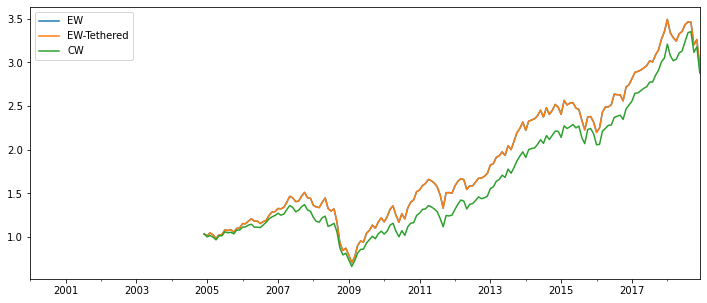

In [95]:
ewr = backtest_ws(ind_rets)
ewtr = backtest_ws(ind_rets, cap_weights=ind_mcap, max_cw_mult=3, microcap_threshold=.005)
cwr = backtest_ws(ind_rets, weighting=weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "EW-Tethered": ewtr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,5))
summary_stats(btr.dropna())

As expected, the EW-Tethered portfolio lies somewhere between EW and CW.

Here's EW's tracking error to CW with and without tethering.

In [96]:
def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())

print('EW Tracking Error: ', tracking_error(ewr, cwr))
print('EW-Tethered Tracking Error: ', tracking_error(ewtr, cwr))

EW Tracking Error:  0.1391559295846079
EW-Tethered Tracking Error:  0.1391559295846079


Tracking error decreased with tethering.

Now let's see if we can improve on these portfolios.

## Maximum Sharpe Ratio (MSR)

If we go back to portfolio theory, we want to maximize the Sharpe Ratio. For this, we'll use the minimize function from scipy and use the Sequential Least Squares Programming Method with two constraints:
- Weights are between 0 and 1
- Weights sum up to 1

These constraints make the result interpretable as weights in a portfolio.

In [97]:
from scipy.optimize import minimize

def msr(riskfree_rate, er, cov):
    """
    RiskFree rate + ER + COV -> Weight vector 'W'
    """
    n = er.shape[0]
    # Initial guess is an equally weighted portfoliio
    init_guess = np.repeat(1/n, n)
    # Constraint 1: weights are between 0 and 1
    bounds = ((0.0, 1.0),)*n
    # Constraint 2: weights sum up to 1
    weights_sum_to_1 = {
        # The type of constraint is an equality
        'type': 'eq',
        # The function is the sum of the weights minus 1 equal 0
        'fun': lambda weights: np.sum(weights) - 1
    }
    
    # Using negative Sharpe Ratio because this is a minimizing optimizer
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns negative of the Sharpe ratio, given weights
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess,
                       args=(riskfree_rate, er, cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

The problem with MSR is that it is extremely sensitive to our estimation of returns (and therefore has a very high sample bias). It often gives exteme solutions like putting all your capital into one asset.

So, instead of using MSR, can we avoid having to estimate returns in the first place?

## Global Minimum Variance (GMV)

If we assume returns are the same across assets, the optimizer we laid out above can only improve the Sharpe Ratio through lowering variance, so we can build on the same function to find the  GMV portfolio.

In theory it's not as good as the Max Sharpe Ratio portfolio, but it's still on the efficient frontier and is potentially more robust as it doesn't rely on us estimating returns.

However, it does still rely on us estimating covariance, so we will first estimate sample covariance.

In [98]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given returns and a covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
CW,0.077942,0.146264,-0.732819,5.047819,0.068674,0.099002,0.318835,-0.516501
GMV-Sample,0.096126,0.089917,-0.649591,4.516045,0.038336,0.053190,0.715686,-0.262796


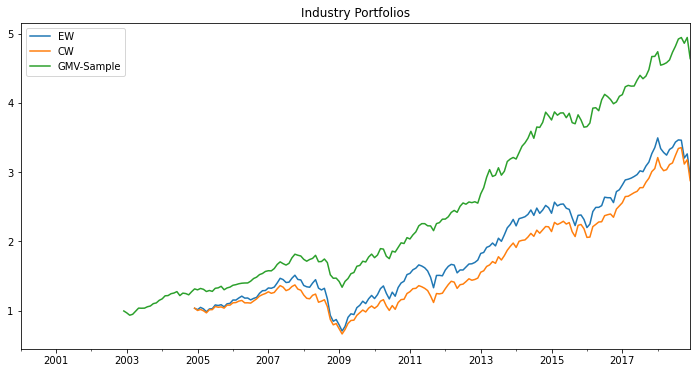

In [99]:
mv_s_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({'EW':ewr, 'CW':cwr, 'GMV-Sample': mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title='Industry Portfolios')
summary_stats(btr.dropna())

Wow - the reduction in volatility significantly raised the Sharpe Ratio. Meanwhile the returns are similar to the cap-weighted portfolio.

### GMV with a Constant Correlation Covariance Estimate 

But here we are again relying on the sample estimate of covariance. Can we avoid doing this? We could assume constant correlation across assets.

Let's try a different estimator for covariance, the Constant Correlation estimator. Take the sample covariance matrix, find average correlation, and use this to reconstruct the covariance matrix. The relationship between correlation and covariance is:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$

where:
$ \rho_{ij} $ is the correlation between assets i and j, 
$ \sigma_{ij} $ is the covariance between assets i and j, 
$ \sigma_{ii} $ is the standard deviation of asset i, and 
$ \sigma_{jj} $ is the standard deviation of asset j

In [100]:
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    #This is a symmetric matrix with diagonals all 1 - so the mean correlation is...
    # Subtracting n because there are n 1's in the diagonal
    # So there are (n^2 - n) values we are averaging over - this is the denominator
    rho_bar= (rhos.values.sum()-n)/(n*(n-1))
    #Now create a new correlation matrix and fill it with rho_bar's
    ccor = np.full_like(rhos, rho_bar)
    #Except we want the diagonal to be 1's
    np.fill_diagonal(ccor, 1.)
    #Now reconstruct the covariance matrix. First find the standard deviation
    sd = r.std()
    # Now multiply correlations by outer product of standard deviations
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

Let's see how the weights of the portfolios look, including GMV portfolios with both sample covariance estimates and constant correlation estimates.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
CW,0.077942,0.146264,-0.732819,5.047819,0.068674,0.099002,0.318835,-0.516501
GMV-Sample,0.096126,0.089917,-0.649591,4.516045,0.038336,0.053190,0.715686,-0.262796
GMV-CC,0.091033,0.097339,-0.799681,4.923034,0.043345,0.064775,0.610158,-0.265704


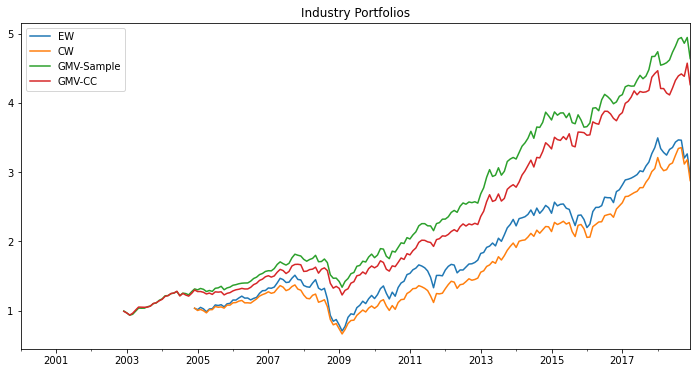

In [101]:
mv_cc_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())

### GMV Portfolio with Shrinkage

We can also meet in the middle and use a shrinkage method that combines the sample covariance estimate and the constant correlation covariance estimate.

In [102]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

Now, we can work out the GMV portfolio weights using either: 1) sample covariance, 2) constant correlation, or 3) shrinkage.

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
CW,0.077942,0.146264,-0.732819,5.047819,0.068674,0.099002,0.318835,-0.516501
GMV-Sample,0.096126,0.089917,-0.649591,4.516045,0.038336,0.053190,0.715686,-0.262796
GMV-CC,0.091033,0.097339,-0.799681,4.923034,0.043345,0.064775,0.610158,-0.265704
GMV-Shrink 0.5,0.095220,0.092145,-0.759209,4.848778,0.040108,0.058035,0.688798,-0.258928


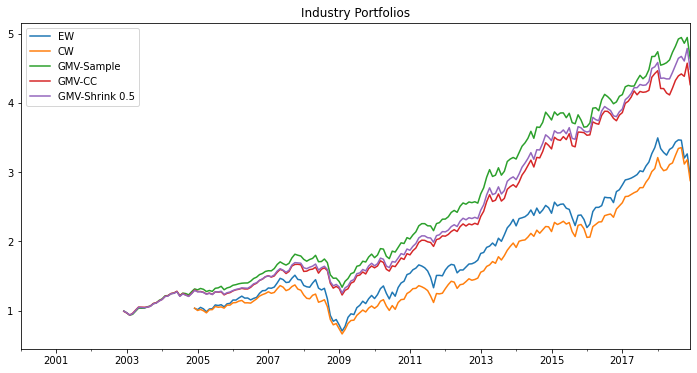

In [103]:
mv_sh_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())

## Equal Risk Contribution (ERC)

What if we equally weighted the portfolio, but not in terms of the nominal number of assets (in this case industries), instead in terms of their risk allocation?

Once again, we can use different estimates for covariance.

In [104]:
def risk_contribution(w, cov):
    """
    Compute the contributions to risk of the constituents of a portfolio,
    given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w, cov)**2
    #Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib, w.T) / total_portfolio_var
    return risk_contrib

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio such that the contributions
    to portfolio  risk are as close as possible to the target_risk, 
    given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n #an N-tuple of 2-tuples
    #construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                       'fun': lambda weights: np.sum(weights) - 1
                       }
    #Objective function to minimize is Mean Squared Difference of
    #risk contributions between current weights' risk and target risk
    #Note technically its the total squared difference not the mean,
    #but we get the same solution so we leave as is
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs - target_risk)**2).sum()
    
    weights = minimize(msd_risk, init_guess,
                      args=(target_risk, cov), method='SLSQP',
                      options={'disp':False},
                      constraints=(weights_sum_to_1,),
                      bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the risk contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the Equal Risk Contribution (ERC) portfolio
    given returns and a covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)

Let's have a final look at all the portfolios we've constructed. Before we go to our backtest, here's a glimpse of what the weighting of each looks like.

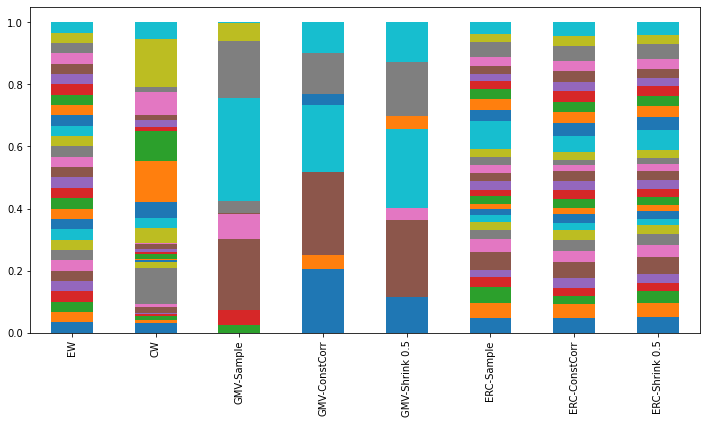

In [105]:
wts = pd.DataFrame({
    "EW": weight_ew(ind_rets["2016":]),
    "CW": weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2016":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind_rets["2016":], cov_estimator=shrinkage_cov),
    "ERC-Sample": weight_erc(ind_rets["2016":], cov_estimator=sample_cov),
    "ERC-ConstCorr": weight_erc(ind_rets["2016":], cov_estimator=cc_cov),
    "ERC-Shrink 0.5": weight_erc(ind_rets["2016":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.079810,0.160713,-0.594110,5.982651,0.073299,0.107935,0.301447,-0.532980
CW,0.077942,0.146264,-0.732819,5.047819,0.068674,0.099002,0.318835,-0.516501
GMV-Sample,0.096126,0.089917,-0.649591,4.516045,0.038336,0.053190,0.715686,-0.262796
GMV-CC,0.091033,0.097339,-0.799681,4.923034,0.043345,0.064775,0.610158,-0.265704
GMV-Shrink 0.5,0.095220,0.092145,-0.759209,4.848778,0.040108,0.058035,0.688798,-0.258928
ERC-Sample,0.086474,0.138259,-0.745941,5.807519,0.063482,0.094324,0.397387,-0.479932
ERC-CC,0.084301,0.144185,-0.739478,5.773712,0.066591,0.098086,0.366366,-0.499124
ERC-Shrink 0.5,0.085333,0.141427,-0.745535,5.795353,0.065170,0.096350,0.380618,-0.490331


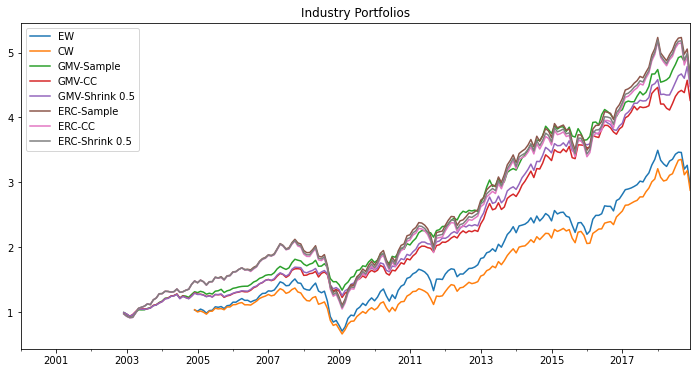

In [106]:
erc_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=sample_cov)
erc_cc_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=cc_cov)
erc_sh_r = backtest_ws(ind_rets, estimation_window=36, weighting=weight_erc, cov_estimator=shrinkage_cov)

btr = pd.DataFrame({"EW": ewr, "CW": cwr, 
                    "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, "GMV-Shrink 0.5": mv_sh_r, 
                    "ERC-Sample": erc_r, "ERC-CC": erc_cc_r, "ERC-Shrink 0.5": erc_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
summary_stats(btr.dropna())

The GMV portfolios tend to perform the best. They have significantly higher Sharpe Ratios, lower Max Drawdowns, and higher returns.

Among these, we have a choice as to how we estimate covariance. Shrinkage may be the best middle ground given we don't want to make too simple of an assumption with constant correlation but we also don't want to rely too heavily on our sample estimate.